In [64]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os
import sys
import glob
import matplotlib
matplotlib.use('nbagg')

sr_path = r'C:\Users\dklev\OneDrive\Documents\GitHub\skilled_reaching_pipeline'
sys.path.append(sr_path)

import skilled_reaching_calibration
import navigation_utilities
import skilled_reaching_io
import computer_vision_basics as cvb

In [52]:
mouse_reaching_parent = r'C:\Users\dklev\OneDrive\Documents\Burgess_local'

video_root_folder = os.path.join(mouse_reaching_parent, 'mouse_SR_videos_tocrop')
cropped_vids_parent = os.path.join(mouse_reaching_parent, 'cropped_mouse_SR_videos')
marked_vids_parent = os.path.join(mouse_reaching_parent, 'marked_mouse_SR_videos')
cal_vids_parent = os.path.join(mouse_reaching_parent, 'mouse_SR_calibration_videos')
cal_data_parent = os.path.join(mouse_reaching_parent, 'mouse_SR_calibration_data')
reconstruct_3d_parent = os.path.join(mouse_reaching_parent, 'mouse_SR_3dreconstructions')
parent_directories = {
'mouse_reaching_parent': mouse_reaching_parent,
'video_root_folder': video_root_folder,
'cropped_vids_parent': cropped_vids_parent,
'marked_vids_parent': marked_vids_parent,
'cal_vids_parent': cal_vids_parent,
'cal_data_parent': cal_data_parent,
'reconstruct3d_parent': reconstruct_3d_parent
}

In [53]:
def fund_mat_from_stereo_pts(cal_data, use_undistorted=True):
    
    pts = []
    for i_cam in range(2):
        if use_undistorted:
            pts.append(np.reshape(cal_data['stereo_imgpoints_ud'][i_cam], (-1,2)))
        else:
            pts.append(np.reshape(cal_data['stereo_imgpoints'][i_cam], (-1,2)))
            
    F = cv2.findFundamentalMat(pts[0], pts[1], cv2.FM_RANSAC, 3, 0.99)
    
    return F

In [54]:
def epilines_from_pts(pts, F, whichImage):
    
    epilines = cv2.computeCorrespondEpilines(pts, whichImage, F)
    
    edge_pts = []
    for i_line, epiline in enumerate(epilines):

        bp_color = color_from_bodypart(bodyparts[i_line])
        epiline = np.squeeze(epiline)
        edge_pts.append(cvb.find_line_edge_coordinates(epiline, im_size))
        
    return edge_pts

In [55]:
cb_size = (7, 10)

In [56]:
cal_folder = r'C:\Users\dklev\OneDrive\Documents\Burgess_local\mouse_SR_calibration_data\calibrationfiles_2021\calibrationfiles_202111'
cal_file = 'calibrationdata_20211115_00-00-00.pickle'
cal_file = os.path.join(cal_folder, cal_file)
cal_data = skilled_reaching_io.read_pickle(cal_file)

cal_metadata = navigation_utilities.parse_optitrack_calibration_data_name(cal_file)
cal_vid_folder = navigation_utilities.find_Burgess_calibration_vid_folder(cal_vids_parent, cal_metadata['datetime'])
cal_vids = glob.glob(os.path.join(cal_vid_folder, '*.avi'))

In [57]:
mtx = cal_data['mtx']
dist = cal_data['dist']

In [61]:
F_ffm, msk = fund_mat_from_stereo_pts(cal_data, use_undistorted=False)
F_ffm_ud, msk_ud = fund_mat_from_stereo_pts(cal_data, use_undistorted=True)

In [59]:
vc = []
for i_cam in range(2):
    vc.append(cv2.VideoCapture(cal_vids[i_cam]))

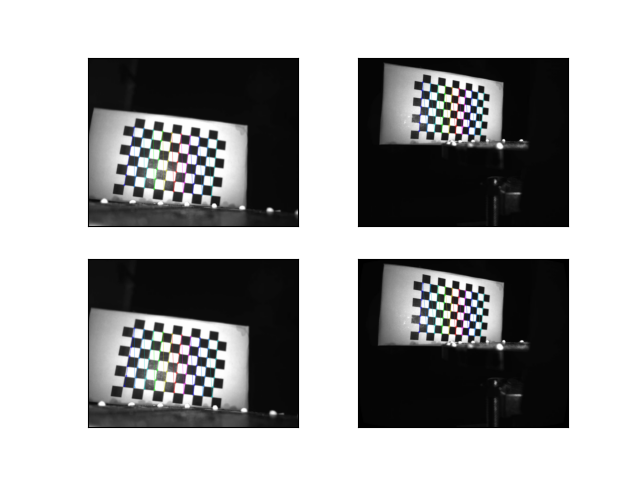

In [66]:
%matplotlib widget
img = []
img_ud = []
cb = []
cb_ud = []
cb_img = []
cb_img_ud = []

epilines_from_F = []

i_frame = 0

fig, axs = plt.subplots(2, 2)

for i_cam in range(2):
    vc[i_cam].set(cv2.CAP_PROP_POS_FRAMES, cal_data['stereo_frames'][i_frame])
    res, frame = vc[i_cam].read()
    
    if i_cam == 0:
        frame = cv2.rotate(frame, cv2.ROTATE_180)
    img.append(frame)
    img_ud.append(cv2.undistort(frame, mtx[i_cam], dist[i_cam]))
    
    cb.append(cal_data['stereo_imgpoints'][i_cam][i_frame])
    cb_ud.append(cal_data['stereo_imgpoints_ud'][i_cam][i_frame])
    
    cb_img.append(cv2.drawChessboardCorners(frame, cb_size, cb[i_cam], True))
    cb_img_ud.append(cv2.drawChessboardCorners(img_ud[i_cam], cb_size, cb[i_cam], True))
    
    axs[0, i_cam].imshow(cb_img[i_cam])
    axs[0, i_cam].tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)
    axs[1, i_cam].imshow(cb_img_ud[i_cam])
    axs[1, i_cam].tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)
    
        
plt.show()